In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
!wget https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv

--2022-12-19 22:16:04--  https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35735 (35K) [text/plain]
Saving to: ‘BostonHousing.csv’

BostonHousing.csv   100%[===================>]  34.90K  --.-KB/s    in 0.002s  

2022-12-19 22:16:04 (13.9 MB/s) - ‘BostonHousing.csv’ saved [35735/35735]



## EDA

In [4]:
boston = pd.read_csv("BostonHousing.csv")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [9]:
boston.shape

(506, 14)

In [43]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
b          float64
lstat      float64
medv       float64
dtype: object

Всего в нашем датасете 14 различных признаков и 506 различных записей. Значение признаков:

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per 10,000 dollars
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in 1000 of dollars

При этом мы видим, что все параметры *chas* и *rad* - категориальные.

Проверим, есть ли где-нибудь отсутствующие значения:

In [5]:
boston.isna().sum() 

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

В нашем датасете нет пустых значений - это хорошо, ничего не нужно дозаполнять. Теперь можем посмотреть распределения различных параметров. 

In [6]:
plt.rcParams["figure.figsize"] = 27, 15
plt.rcParams["font.size"] = 14

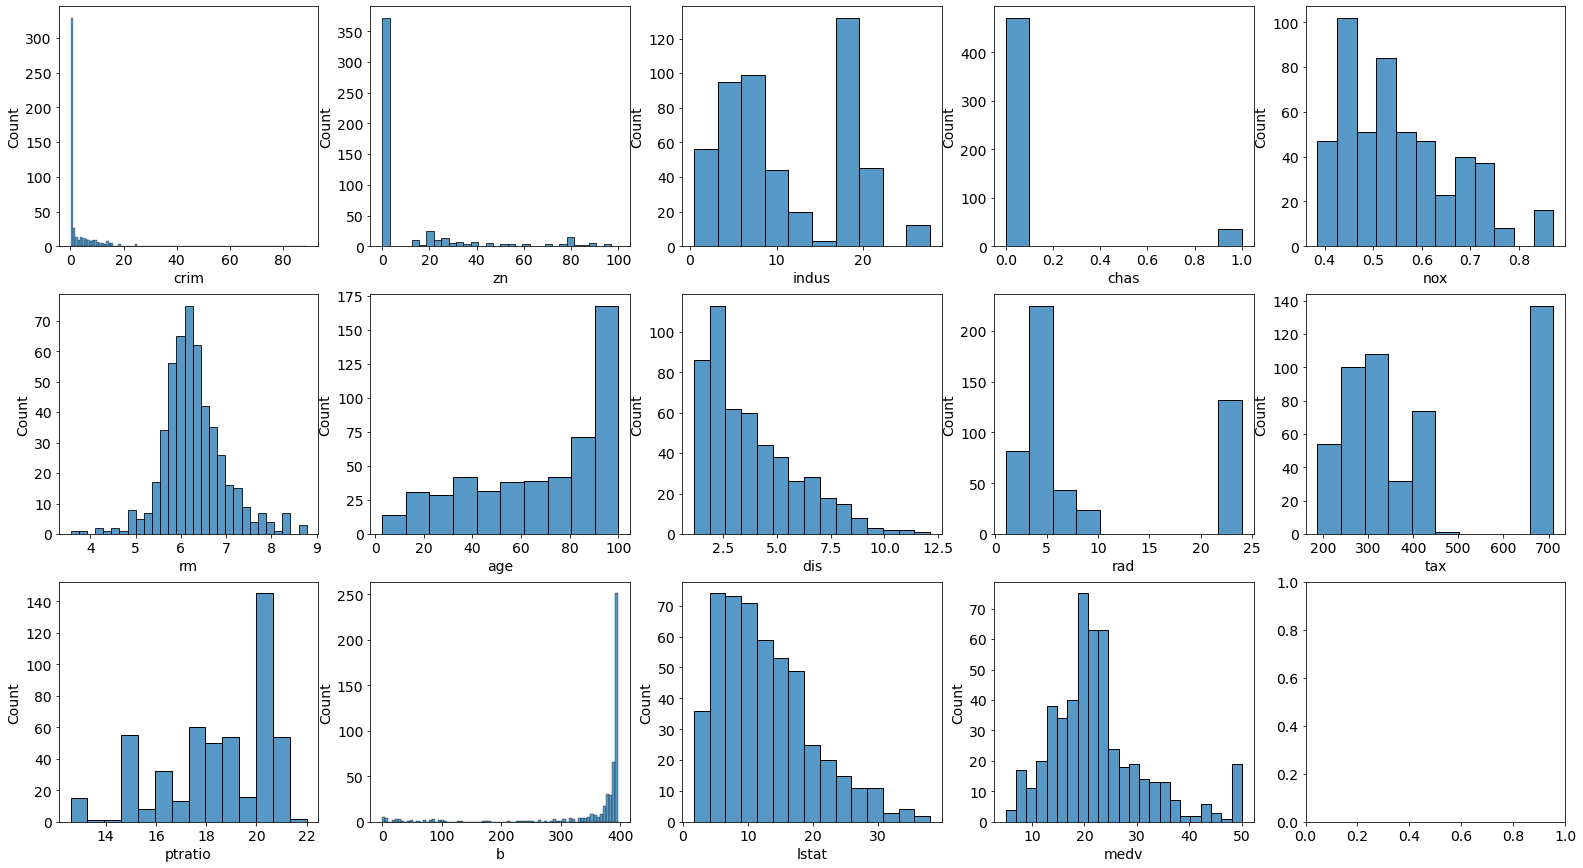

In [17]:
n_rows=3
n_cols=5

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

for i, column in enumerate(boston.columns):
    sns.histplot(boston[column], ax=axes[i//n_cols, i%n_cols])

Мы видим, что для разных параметров у нас разные распределения. Например, близкое к нормальному и bell-shaped распределение у параметров *rm* и *medv*. В то же время для *crim* и *zn* подавляющее число значений находится близко к нулю, а для *b*, наоборот, в районе максимального значения ($\approx$ 400). Остальные значения распределены примерно экспоненциально.

Больше всего в этом задании нас интересует переменная *medv*, для которой мы будем строить модель - она распределена +- нормально.

Теперь можем посмотреть на то, как переменные влияют друг на друга и проверить, есть ли какие-то корреляции:

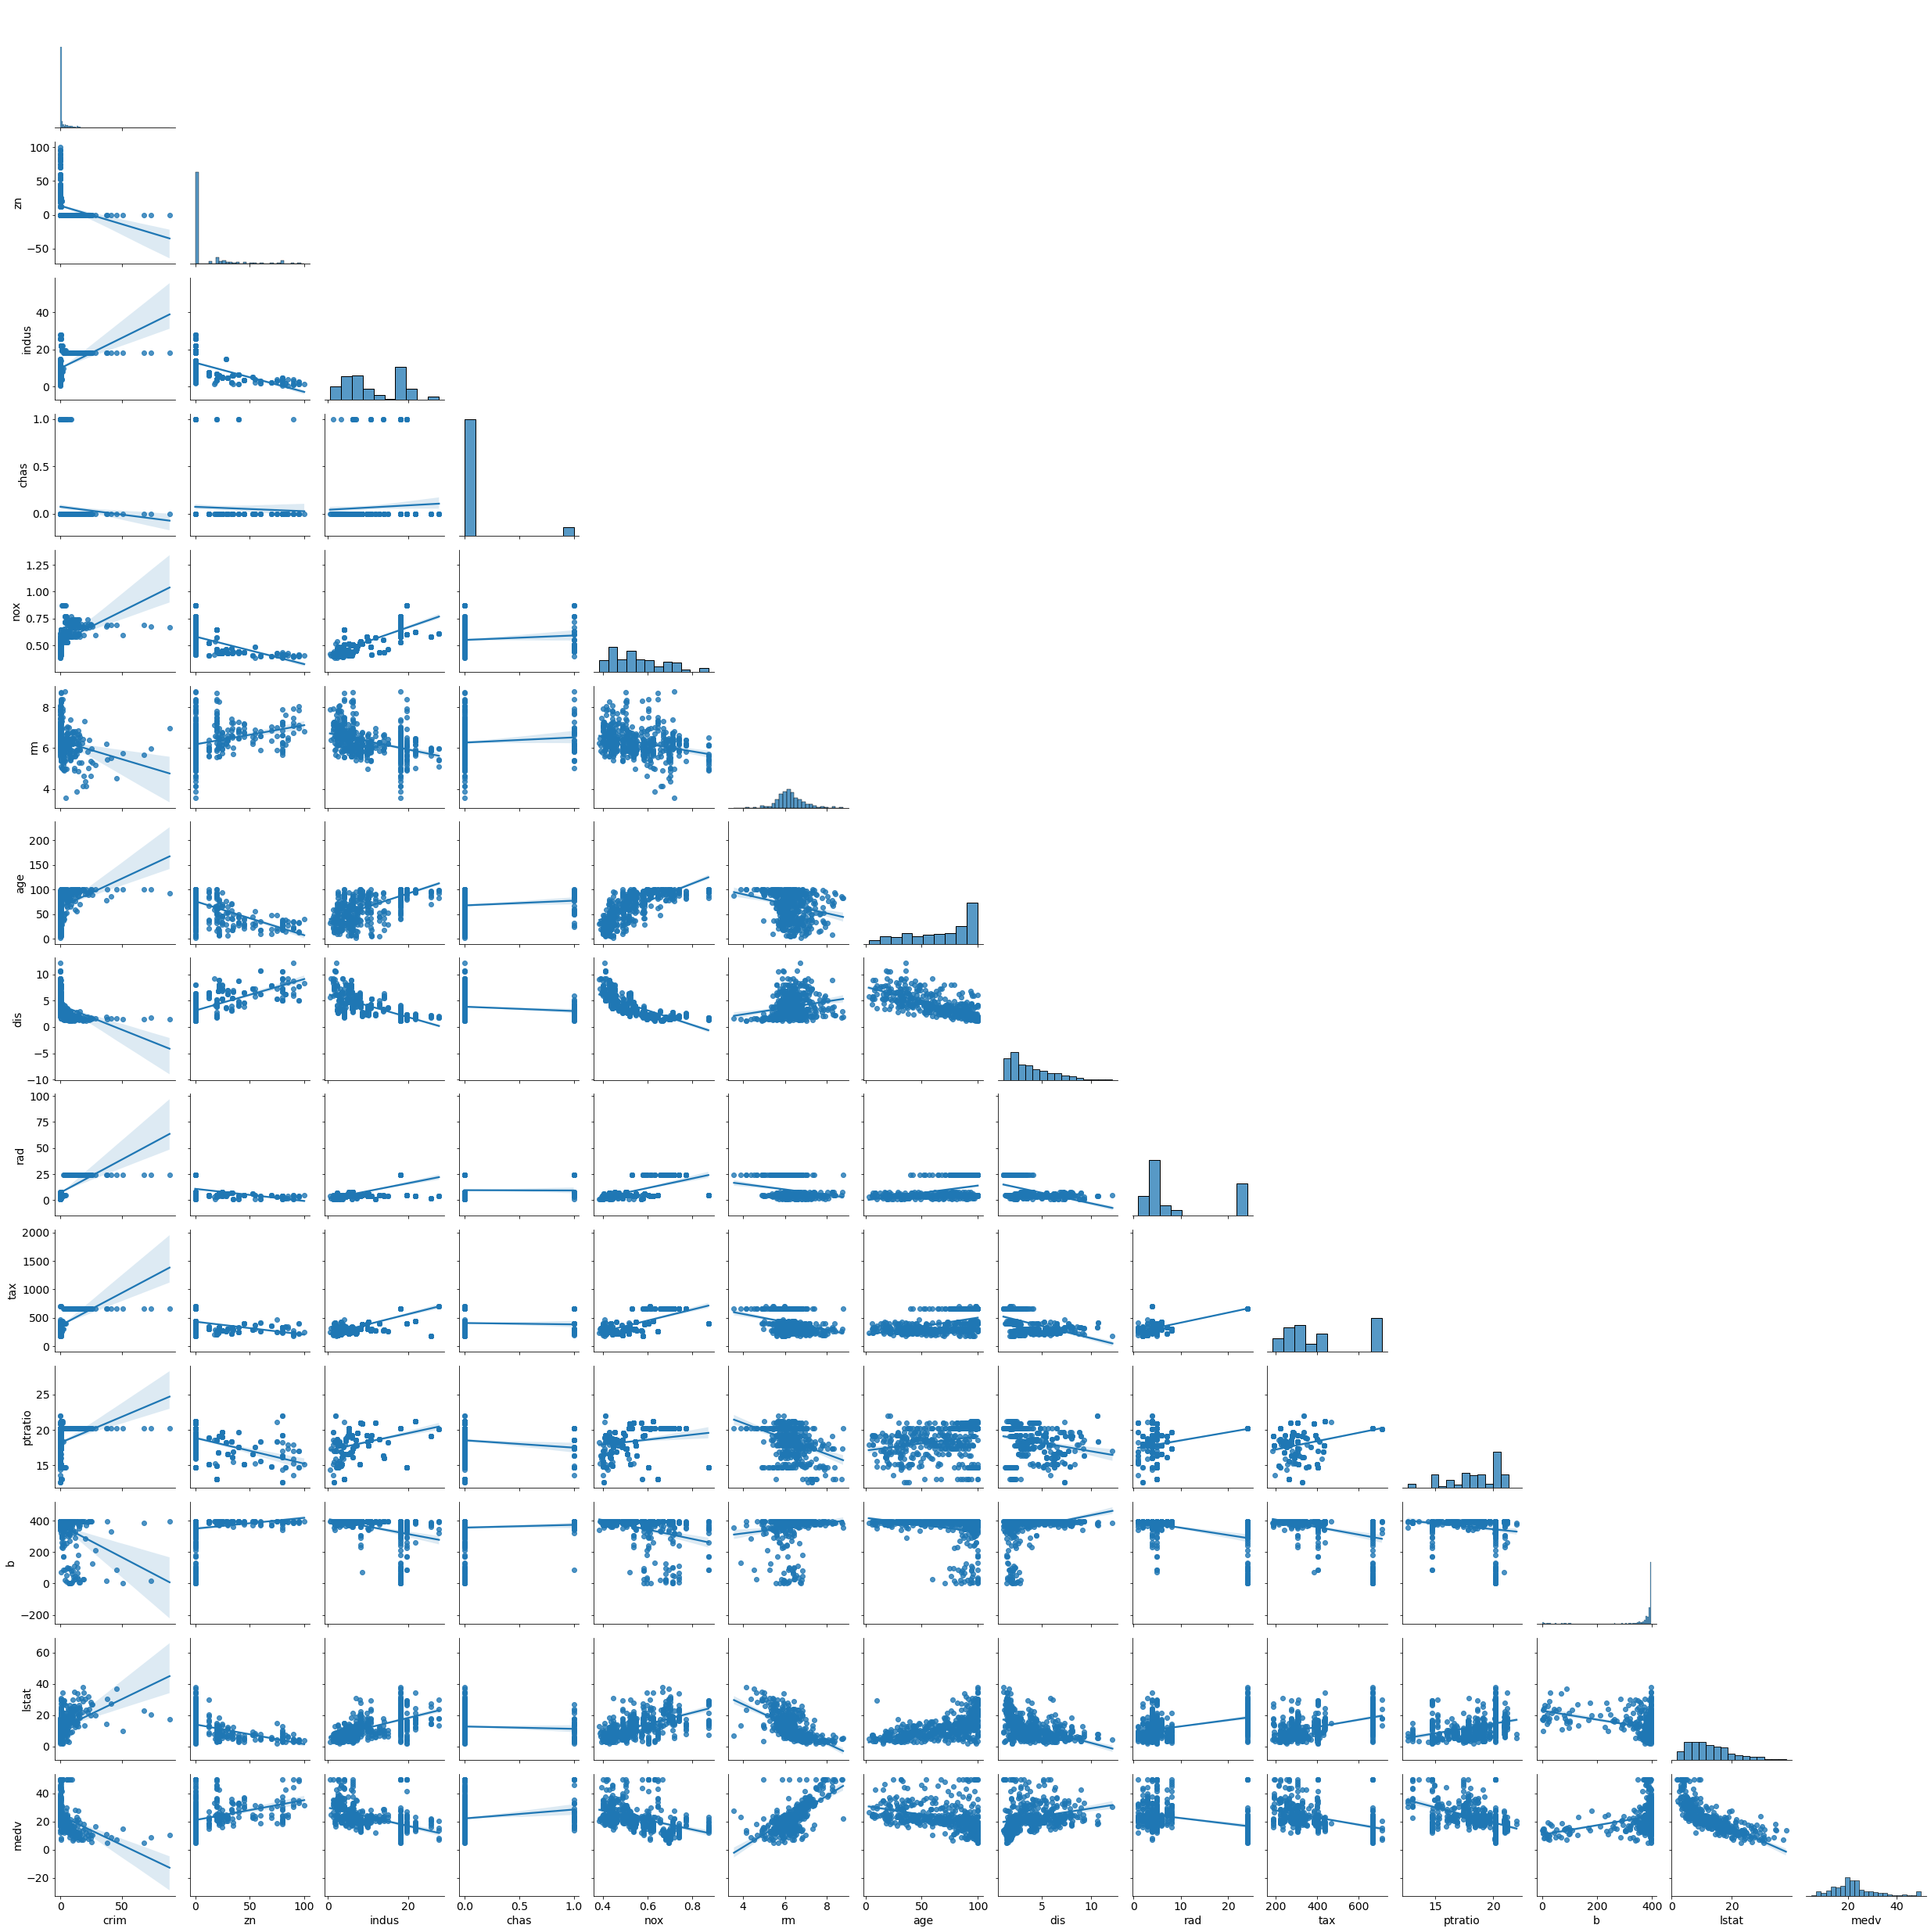

In [7]:
sns.pairplot(boston, kind="reg", corner=True);

Можно заметить две общие вещи: во-первых, параметры *zn* и *indus* имеют положительную и отрицательную корреляцию с большинством параметров; во-вторых, что у нас есть несколько нелинейный взаимодействий (например, *nox-dis* и *lstat-medv*). При этом так или иначе, все параметры имеют какую-то корреляцию с целевой переменной *medv*. Оценивая визуально, наибольший эффект имеют признаки *lstat* и *rm*.

Чтобы проверить эти данные численно, построим матрицу корреляций:

In [8]:
boston.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


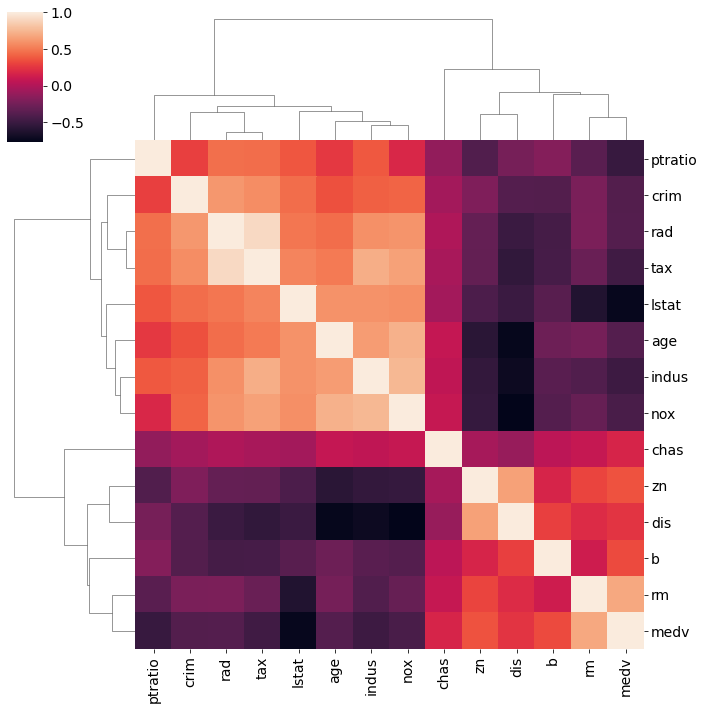

In [11]:
sns.clustermap(boston.corr());

Видно, что наши признаки хорошо разделились на две группы - можно предположить, что датасет хорошо визуализируется с помощью PCA (посмотрим на это ниже).


## Стандартизация признаков

Масштабируем признаки путем стандартизации:

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
boston_ss = pd.DataFrame(data = scaler.fit_transform(boston))

In [73]:
cols = boston.columns
boston_ss.columns = cols

In [74]:
boston_ss.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,-1.123388e-16,7.898820e-17,2.106352e-16,-3.510587e-17,-1.965929e-16,-1.088282e-16,-1.474446e-16,-8.425408e-17,-1.123388e-16,0.000000,-4.212704e-16,-7.442444e-16,-3.089316e-16,-5.195668e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990,-2.707379e+00,-3.907193e+00,-1.531127e+00,-1.908226e+00
25%,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-0.767576,-4.880391e-01,2.050715e-01,-7.994200e-01,-5.994557e-01
50%,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-0.464673,2.748590e-01,3.811865e-01,-1.812536e-01,-1.450593e-01
75%,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926,8.065758e-01,4.336510e-01,6.030188e-01,2.685231e-01
max,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194,1.638828e+00,4.410519e-01,3.548771e+00,2.989460e+00


## Построение и анализ полной линейной модели

Теперь мы можем построить полную модель, используя все параметры.

In [75]:
X = sm.add_constant(boston_ss.drop(columns=["medv"]))
model = sm.OLS(boston_ss['medv'], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          6.72e-135
Time:                        01:51:59   Log-Likelihood:                -376.55
No. Observations:                 506   AIC:                             781.1
Df Residuals:                     492   BIC:                             840.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.235e-16      0.023  -2.28e-14      1.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Видно, что для всех параметров, кроме *age* и *indus*, p-value меньше 0.05, то есть мы можем сказать, что они являются значимыми предикторами. Далее мы можем усовершенствовать модель путем backward elimination, убирая по-одному незначимые параметры.

Далее мы можем посмотреть детальнее на работу нашей модели и коэффициенты.

In [42]:
results.params

const     -5.234528e-16
crim      -1.010171e-01
zn         1.177152e-01
indus      1.533520e-02
chas       7.419883e-02
nox       -2.238480e-01
rm         2.910565e-01
age        2.118638e-03
dis       -3.378363e-01
rad        2.897491e-01
tax       -2.260317e-01
ptratio   -2.242712e-01
b          9.243223e-02
lstat     -4.074469e-01
dtype: float64

Для наглядности можем построить график **коэффициентов**. Чем больше по модулю коэффициент, тем больший вклад вносит данный параметр.

In [ ]:
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"] = 14

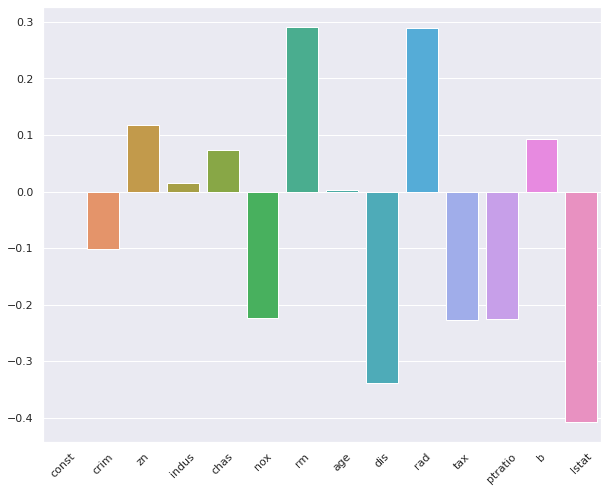

In [48]:
sns.barplot(x=results.params.index, y=results.params)
plt.xticks(rotation=45);

Наибольшим по модулю коэффициентом обрадает параметр *lstat*, посмотрим насколько от нее зависят предсказания и реальные значения: 

In [44]:
prediction_result = results.get_prediction(X)
target_pred = prediction_result.predicted_mean

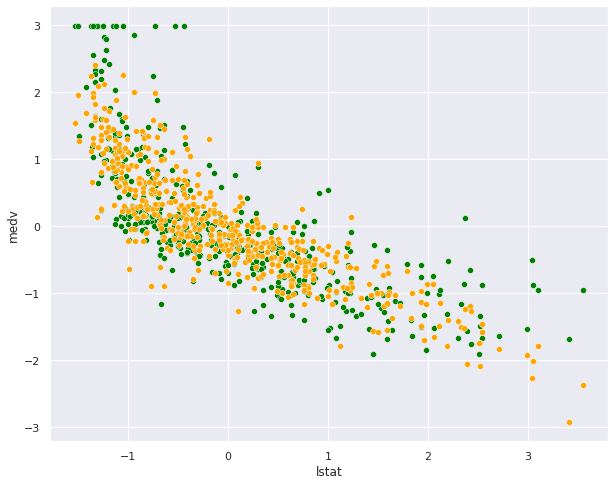

In [52]:
sns.scatterplot(x='lstat', y='medv', data=boston_ss, color = 'green')
sns.scatterplot(x=boston_ss['lstat'], y=target_pred, data=boston_ss, color = 'orange');

Как я и писала выше, этот параметр действительно влияет на целевую переменную (хоть и нелинейно).

Теперь посмотрим в целом на **предсказания** нашей модели:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


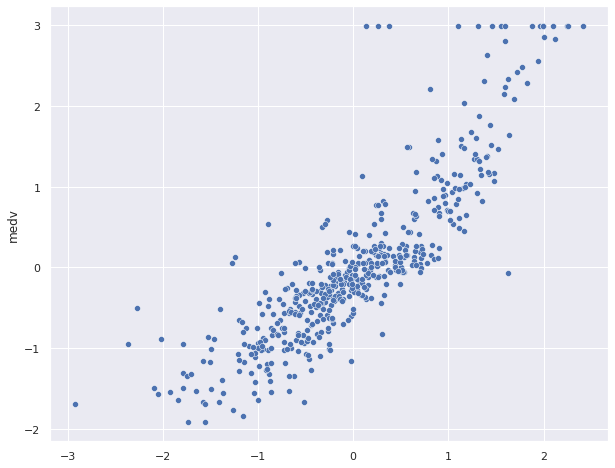

In [47]:
sns.scatterplot(target_pred, boston_ss['medv']);

Можно сказать, что наша модель очень хорошо описывает целевую переменную, однако есть группа **выбросов** с большими значениями, которая модель плохо предсказывает.

Теперь посмотрим на **residuals**:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


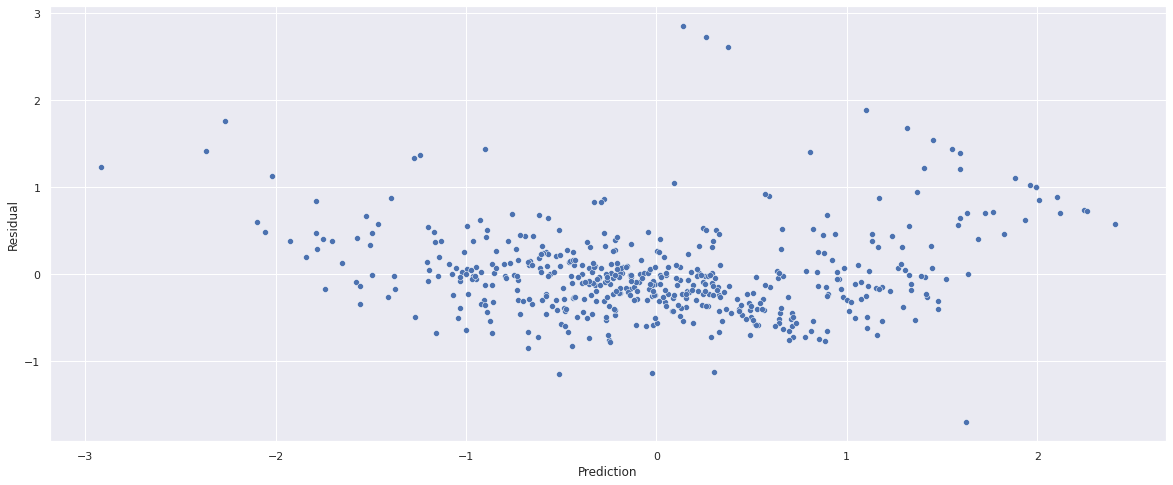

In [85]:
resid_full = boston_ss['medv'] - target_pred
sns.scatterplot(target_pred, resid_full)
plt.xlabel("Prediction")
plt.ylabel("Residual")
plt.show()

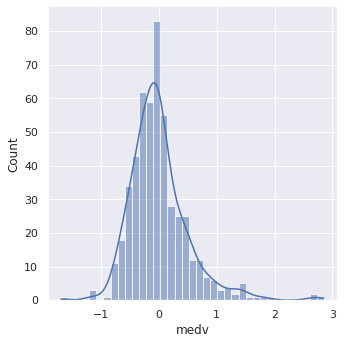

In [68]:
sns.displot(resid_full, kde=True);

Видно, что наши данные в целом распределены нормально, но имеют значительный сдвиг вправо и большое количество около-медианных значений. Посмотрим на Q-Q plot для данных значений остатков:

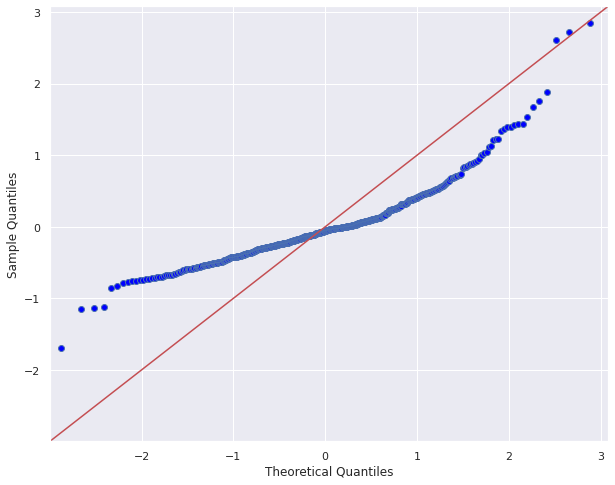

In [70]:
sm.qqplot(resid_full, line='45');

Видно, что кривая значительно откланяется от значений для нормального распределения. Это значит, что число значений в наших квартилях достаточно сильно смещено, вероятно, из-за выбросов. 

Чтобы оценить влияние выбросов на нашу модель, рассчитаем расстояние Кука, используя следующую формулу:

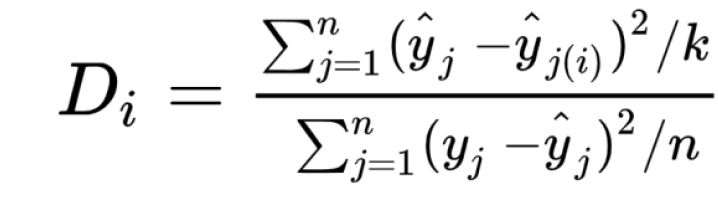

где $\hat y_{j(i)}$ - значение, предсказанное моделью, не учитывающей $i$ наблюдение.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


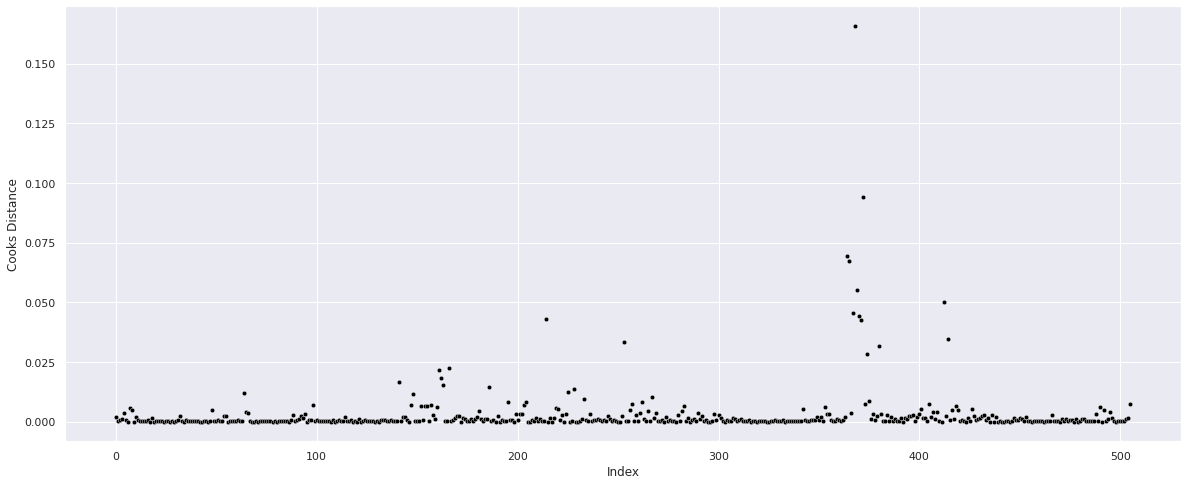

In [84]:
influence = results.get_influence()
cooks = influence.cooks_distance

plt.rcParams["figure.figsize"] = 20, 8
sns.set_theme()
sns.scatterplot(boston_ss.index, cooks[0], s=20, color="black")
plt.xlabel('Index')
plt.ylabel('Cooks Distance')
plt.show()

Видно, что очень большое влияние оказывает группа наблючений с индексами 360-370.

In [89]:
print(sum(cooks[0] > 0.05), sum(cooks[0] > 0.03), sum(cooks[0] > 0.02))

6 13 16


Можем отобрать в новый датафрейм только данные со значением индекса Кука менее 0.02 и посмотреть, насколько улучшится наша модель:

In [90]:
boston_cook = boston_ss[cooks[0] < 0.02]

In [91]:
model_cook = sm.OLS(boston_cook.medv, boston_cook.drop(columns = 'medv'))
results_cook = model_cook.fit()

print(results_cook.summary())

                                 OLS Regression Results                                
Dep. Variable:                   medv   R-squared (uncentered):                   0.832
Model:                            OLS   Adj. R-squared (uncentered):              0.827
Method:                 Least Squares   F-statistic:                              181.4
Date:                Tue, 20 Dec 2022   Prob (F-statistic):                   3.89e-175
Time:                        02:10:45   Log-Likelihood:                         -228.01
No. Observations:                 490   AIC:                                      482.0
Df Residuals:                     477   BIC:                                      536.5
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Видим, что данная модель работает лучше, поскольку понизился p-value и AIC и повысился R^2. 


Для того, чтобы еще улучшить нашу модель, нужно убрать коррелирующие между собой параметры. Мы можем это сделать, основываясь на значениях **Variance inflation factor (VIF)**.

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [97]:
target = boston_cook.medv
X = boston_cook.drop(columns = ['medv'])

In [95]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]

    return vif_data

In [99]:
calculate_vif(X)

,feature,VIF
0,crim,1.991417
1,zn,2.361202
2,indus,3.978925
3,chas,1.071790
4,nox,4.475445
5,rm,2.240018
6,age,3.311402
7,dis,3.994376
8,rad,7.382231
9,tax,8.554432


Наибольшее значение у признака *tax* - уберем этот признак и построим модель:

In [100]:
model_updated = sm.OLS(target, X.drop(columns=["tax"]))
results_updated = model_updated.fit()

print(results_updated.summary())

                                 OLS Regression Results                                
Dep. Variable:                   medv   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.821
Method:                 Least Squares   F-statistic:                              188.1
Date:                Tue, 20 Dec 2022   Prob (F-statistic):                   2.36e-172
Time:                        02:24:14   Log-Likelihood:                         -237.34
No. Observations:                 490   AIC:                                      498.7
Df Residuals:                     478   BIC:                                      549.0
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Видим, что признак *rad*, который тоже имеет высокий VIF все еще незначим - уберем его тоже и повторим построение модели:

In [101]:
model_updated = sm.OLS(target, X.drop(columns=["tax", "rad"]))
results_updated = model_updated.fit()

print(results_updated.summary())

                                 OLS Regression Results                                
Dep. Variable:                   medv   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.821
Method:                 Least Squares   F-statistic:                              205.6
Date:                Tue, 20 Dec 2022   Prob (F-statistic):                   1.64e-173
Time:                        02:27:11   Log-Likelihood:                         -237.36
No. Observations:                 490   AIC:                                      496.7
Df Residuals:                     479   BIC:                                      542.9
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [102]:
calculate_vif(X.drop(columns=["tax", "rad"]))

,feature,VIF
0,crim,1.558267
1,zn,2.235549
2,indus,3.209598
3,chas,1.052627
4,nox,3.949775
5,rm,2.077597
6,age,3.246581
7,dis,3.984642
8,ptratio,1.532897
9,b,1.356436


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


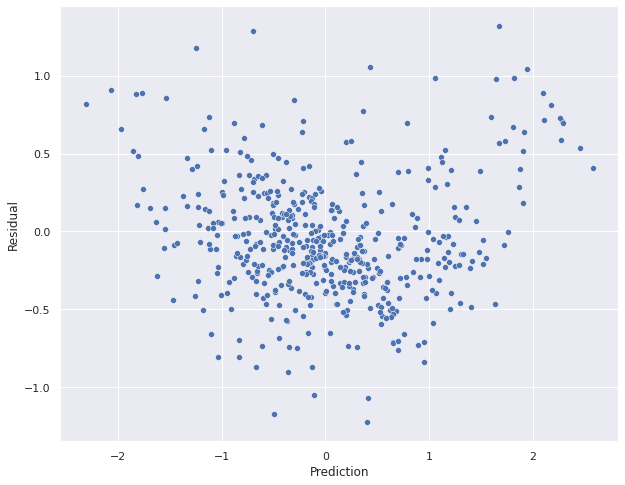

In [104]:
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"] = 14

prediction_result = results_updated.get_prediction(X.drop(columns=["tax", "rad"]))
target_pred = prediction_result.predicted_mean

resid_full = boston_cook['medv'] - target_pred
sns.scatterplot(target_pred, resid_full)
plt.xlabel("Prediction")
plt.ylabel("Residual")
plt.show()

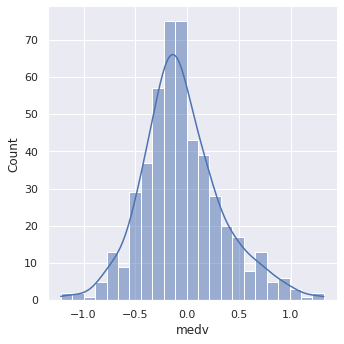

In [105]:
sns.displot(resid_full, kde=True);

Видно, что распределение остатнов новой модели более похоже на нормальное и не имеет такого сильного смещения. Посмотрим на Q-Q plot: 

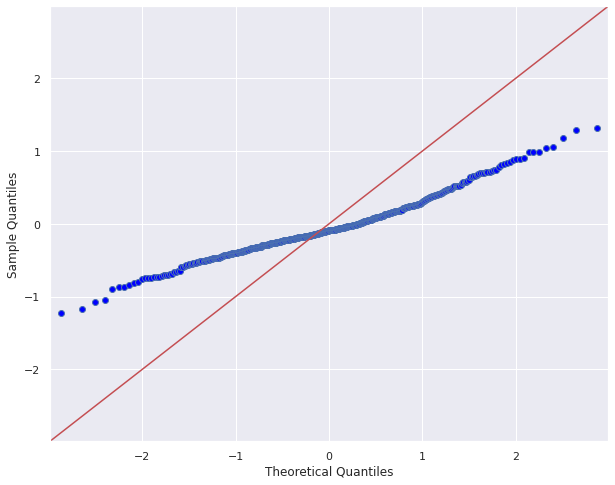

In [106]:
sm.qqplot(resid_full, line='45');

Наша модель все еще далека от идеала, поскольку отстатки все еще не лежат на прямой нормального распределения.

Мы можем убрать также последние параметры, для которых высокий VIF и $p-value > 0.05$.

In [120]:
model_updated1 = sm.OLS(target, X.drop(columns=["tax", "rad", "zn", "indus"]))
results_updated1 = model_updated1.fit()

print(results_updated1.summary())

                                 OLS Regression Results                                
Dep. Variable:                   medv   R-squared (uncentered):                   0.823
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                              247.8
Date:                Tue, 20 Dec 2022   Prob (F-statistic):                   2.26e-174
Time:                        02:53:03   Log-Likelihood:                         -240.99
No. Observations:                 490   AIC:                                      500.0
Df Residuals:                     481   BIC:                                      537.7
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

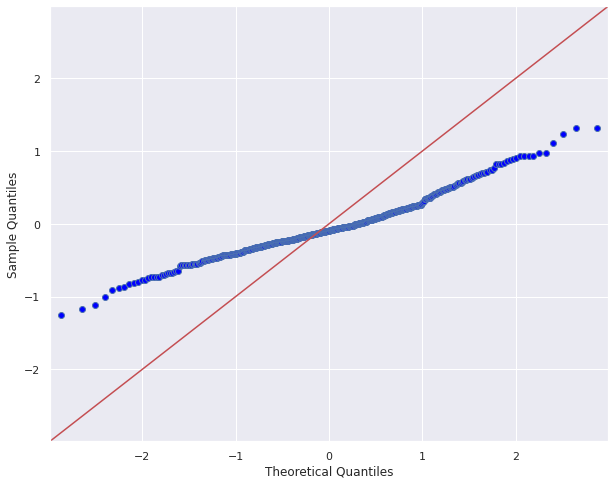

In [122]:
prediction_result = results_updated1.get_prediction(X.drop(columns=["tax", "rad", "zn", "indus"]))
target_pred = prediction_result.predicted_mean

resid_full = boston_cook['medv'] - target_pred
sm.qqplot(resid_full, line='45');

Видим, что уже почти никакие параметры модели не меняются. Подводя итог, можно сказать, что нам есть куда стремиться и, вероятно, все-таки использовать не линейную регрессию в этой задаче, поскольку здесь имеется большое количество коррелирующих параметров. 

Для того, чтобы определить, какой дом будет лучшим выбором, мы можем посмотреть на коэффициенты последней модели:

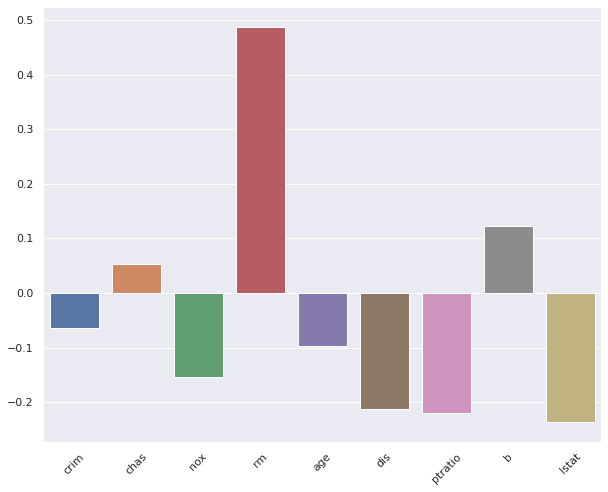

In [123]:
results_updated1.params
sns.barplot(x=results_updated1.params.index, y=results_updated1.params)
plt.xticks(rotation=45);

Итого, рецепт самого дорогого дома будет состоять в следующем: большое количество комнат и процент населения с низким статусом должен быть как можно ниже. Помимо этого, стоит выбирать дома, которые ближе всего к бизнес-центрам города, а так же дома в районах с наименьшим индексом ученик-учитель.

## PCA (for fun)

Выделим первую главную компоненту и посмотрим как она описывает целевую переменную:

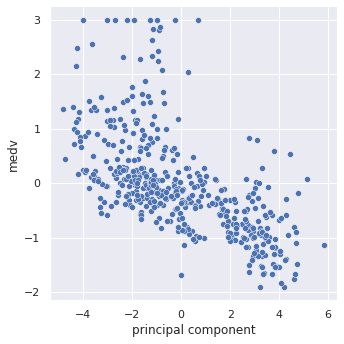

In [114]:
from sklearn.decomposition import PCA

# построение компоненты
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(boston_cook.drop(columns=["medv"]))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component'])

# склеиваем компоненту и целевую переменную
finalDf = pd.concat([principalDf, boston_cook[['medv']]], axis = 1)

sns.relplot(x='principal component', y='medv', data = finalDf);

Видно, что первая компонента очень хорошо описывает целевую переменную *medv*! Можем попробовать построить еще вторую:

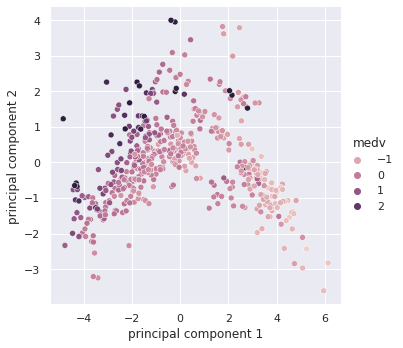

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(boston_ss.drop(columns=["medv"]))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, boston_ss[['medv']]], axis = 1)

sns.relplot(x='principal component 1', y='principal component 2',
           #size='medv', sizes=(40, 400), alpha=.5,
            hue='medv',
            data = finalDf);

In [115]:
model_pc1 = sm.OLS(boston_cook.medv, principalComponents)
results_pc1 = model_pc1.fit()

print(results_pc1.summary())

                                 OLS Regression Results                                
Dep. Variable:                   medv   R-squared (uncentered):                   0.471
Model:                            OLS   Adj. R-squared (uncentered):              0.470
Method:                 Least Squares   F-statistic:                              436.1
Date:                Tue, 20 Dec 2022   Prob (F-statistic):                    1.06e-69
Time:                        02:45:08   Log-Likelihood:                         -508.50
No. Observations:                 490   AIC:                                      1019.
Df Residuals:                     489   BIC:                                      1023.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

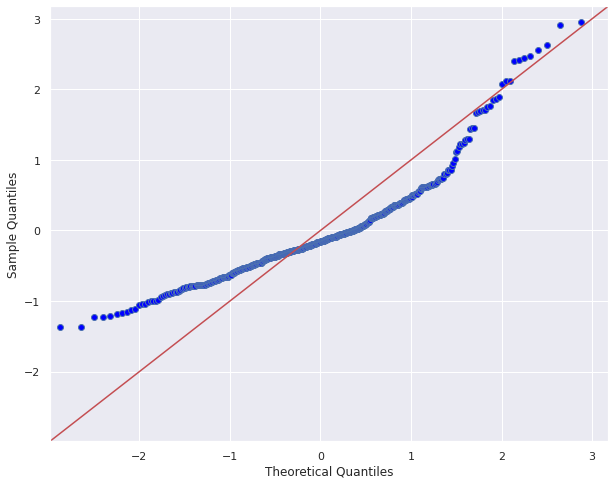

In [117]:
prediction_result = results_pc1.get_prediction(principalComponents)
target_pred = prediction_result.predicted_mean

resid_full = boston_cook['medv'] - target_pred

sm.qqplot(resid_full, line='45');

К сожалению, эта модель работает даже хуже предыдущих.